In [1]:
import csv
import os

import biosppy.signals.ecg as ecg
import biosppy
import neurokit2 as nk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

DATAPATH = "/Users/ericschreiber/dev/ETH/AML/Project_1/aml-2023/task2/data"

In [2]:
X_train_raw = pd.read_csv(DATAPATH + "/X_train.csv", index_col="id")
X_test_raw = pd.read_csv(DATAPATH + "/X_test.csv", index_col="id")
y_train_raw = pd.read_csv(DATAPATH + "/y_train.csv", index_col="id")

In [3]:
X_train_raw

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17797,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806
id,,,,,,,,,,,,,,,,,,,,,
0,-13,-9,-6,-4,0,2,6,12,23,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-34,110,249,390,527,639,721,777,823,845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-34,-36,-37,-39,-41,-42,-44,-46,-48,-51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,292,298,303,310,320,336,354,377,405,419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,157,179,195,210,217,222,226,228,231,233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,-247,-271,-285,-303,-334,-376,-413,-432,-443,-451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5113,62,62,61,61,61,61,61,61,61,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,-95,-110,-124,-131,-126,-114,-95,-67,-42,-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
from scipy.fftpack import fft
import scipy.fftpack as sf

# array used for frequency content, based on MrBird [1]
freq_array = [
    0.46981001,
    0.94989355,
    1.34722766,
    1.92037653,
    2.45140581,
    3.58897684,
    5.61198292,
    7.85416366,
    11.77742192,
    19.56926069,
]


def extract_fft_heartbeat(heartbeat, n=10, freq_array=freq_array):
    fourier_specture = np.abs(fft(heartbeat))
    freqs = sf.fftfreq(len(fourier_specture), 1.0 / 300.0)
    fourier_specture = fourier_specture[freqs >= 0]
    freqs = freqs[freqs >= 0]

    # cut even more base on the freq_array
    fourier_specture = fourier_specture[freqs <= freq_array[-1]]
    freqs = freqs[freqs <= freq_array[-1]]

    # compute the sums of frequency bands
    sums = []
    sums.append(np.sum(fourier_specture[freqs <= freq_array[0]]))
    for i in range(len(freq_array) - 1):
        sum = np.sum(
            fourier_specture[
                np.logical_and(freqs > freq_array[i], freqs <= freq_array[i + 1])
            ]
        )
        sums.append(sum)

    # own guesses
    # peak_locs = np.argsort(fourier_specture)[0:n]
    # peaks = fourier_specture[peak_locs]
    # one_percent_quantile = np.quantile(fourier_specture,0.99)
    # five_percent_quantile = np.quantile(fourier_specture,0.95)
    # ten_percent_quantile = np.quantile(fourier_specture,0.90)
    # num_non_zero = np.sum(fourier_specture > 0.1)

    return sums


def extract_fft_feature(clean_signal):
    _, info = nk.ecg_peaks(ecg_cleaned=clean_signal, sampling_rate=300)
    fft_features = []
    n_peaks = 10
    # fft_features.append(np.array(extract_fft_heartbeat(clean_signal, n_peaks)))
    peaks = info["ECG_R_Peaks"]
    beats = biosppy.signals.ecg.extract_heartbeats(
        signal=clean_signal, rpeaks=peaks, sampling_rate=300
    )["templates"]
    n_beats = len(beats)
    for i in range(n_beats):
        fft_features.append(np.array(extract_fft_heartbeat(beats[i], n_peaks)))

    fft_features = list(np.array(fft_features).T)

    print(fft_features)
    quit()

    return fft_features

10
10
(746.9554802209811+4703.836063263145j)
6993
freq_left = 816


/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


Text(0.5, 1.0, 'FFT of full signal')

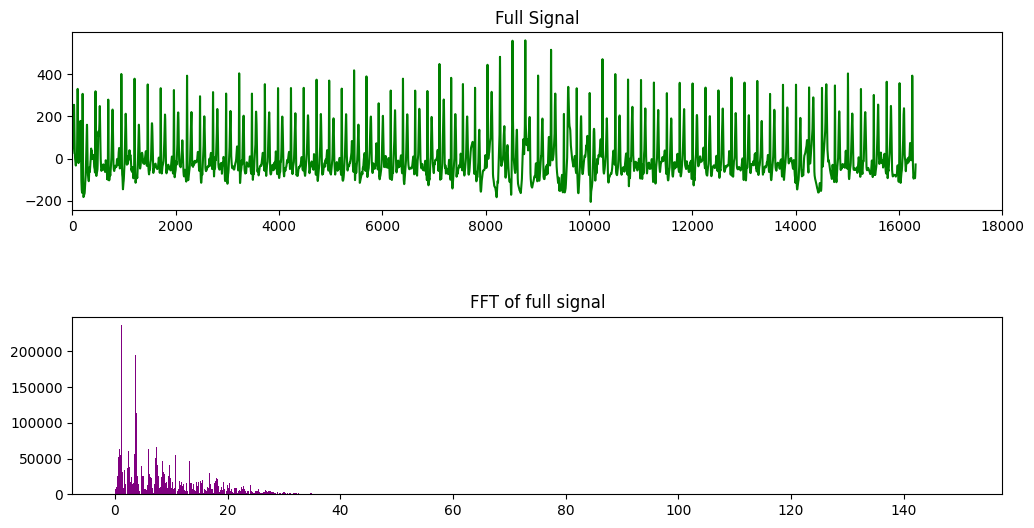

In [5]:
# Test Fourier
signal = X_train_raw.iloc[0].dropna().to_numpy(dtype="float32")
try:
    clean_signal = nk.ecg_clean(signal, sampling_rate=300, method="neurokit")
except:
    try:
        clean_signal = nk.ecg_clean(signal, sampling_rate=300, method="hamilton2002")
    except:
        try:
            clean_signal = nk.ecg_clean(signal, sampling_rate=300, method="elgendi2010")
        except:
            print(f"Fail")

ff = extract_fft_heartbeat(heartbeat=clean_signal)
test = extract_fft_feature(clean_signal=clean_signal)
print(len(test))
print(len(ff))
n = 8000
fourier_specture = fft(clean_signal)
fft_freq = sf.fftfreq(len(fourier_specture)) * 300
fourier_specture = fourier_specture[fft_freq >= 0]
fft_freq = fft_freq[fft_freq >= 0]
print(np.quantile(fourier_specture, 0.9))
print(np.sum(fourier_specture > 1))
fft_mask = fourier_specture > np.quantile(fourier_specture, 0.9)
print(f"freq_left = {np.sum(fft_mask)}")
fourier_specture = np.multiply(fourier_specture, fft_mask)

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(2, 1, hspace=0.6)

full_signal = fig.add_subplot(grid[0, 0])
fft_comp = fig.add_subplot(grid[1, 0])

full_signal.plot(np.arange(len(clean_signal)), clean_signal[0:], color="green")
# full_signal.plot(fft_sample, x_sin, color = 'blue')
full_signal.set_xlim(0, 18000)
full_signal.set_title("Full Signal")
fft_comp.bar(fft_freq, list(fourier_specture), 0.1, color="purple")
# fft_comp.set_xlim(-10,10)
# fft_comp.set_ylim(0, 1)
fft_comp.set_title("FFT of full signal")

In [6]:
import sys

empty = np.empty(1)
empty[:] = np.nan


def get_pqrst_peaks(data):
    p_peaks = []
    q_peaks = []
    r_peaks_loc = []
    s_peaks = []
    t_peaks = []
    p_amp = []
    q_amp = []
    r_amp = []
    s_amp = []
    t_amp = []
    templates = ecg.ecg(signal=data, sampling_rate=300, show=False)["templates"]
    for template in templates:
        # calculate the locations
        try:
            # get local maximas and minimas with signal library
            loc_max = np.array(sp.signal.argrelextrema(template, np.greater))
            loc_min = np.array(sp.signal.argrelextrema(template, np.less))
            # find the maximum, but cut the search area to the first half to avoid
            # finding peaks at the wrong place
            r = np.argmax(template[: int(len(template) / 2)])

            # q and s are the first minima after and before the r value
            q = loc_min[loc_min < r][-1]
            s = loc_min[loc_min > r][0]
            # p and t are the first maxima after and before the r value
            p = loc_max[loc_max < r][-1]
            t = loc_max[loc_max > r][0]

            r_peaks_loc.append(r)
            q_peaks.append(q)
            s_peaks.append(s)
            p_peaks.append(p)
            t_peaks.append(t)
        except:
            ex = 0
            r_peaks_loc.append(ex)
            q_peaks.append(ex)
            s_peaks.append(ex)
            p_peaks.append(ex)
            t_peaks.append(ex)
        try:
            r_a = template[r]
            p_a = template[p]
            q_a = template[q]
            s_a = template[s]
            t_a = template[t]

            t_amp.append[t_a]
            p_amp.append[p_a]
            q_amp.append[q_a]
            s_amp.append[s_a]
            r_amp.append[r_a]
        except:
            ex = 0
            r_amp.append(ex)
            q_amp.append(ex)
            s_amp.append(ex)
            p_amp.append(ex)
            t_amp.append(ex)

    peaks = [
        np.array(p_peaks),
        np.array(q_peaks),
        np.array(r_peaks_loc),
        np.array(s_peaks),
        np.array(t_peaks),
    ]
    amps = [
        np.array(p_amp),
        np.array(q_amp),
        np.array(r_amp),
        np.array(s_amp),
        np.array(t_amp),
    ]

    return peaks, amps


# very bad almost never works
def get_pqrst_peaks_biosppy(data):
    try:
        ecg_ret = ecg.ecg(signal=data, sampling_rate=300, show=False)
        p_peaks = ecg.getPPositions(ecg_proc=ecg_ret)
        q_peaks = ecg.getQPositions(ecg_proc=ecg_ret)
        r_peaks = ecg_ret["rpeaks"]
        s_peaks = ecg.getSPositions(ecg_proc=ecg_ret)
        t_peaks = ecg.getTPositions(ecg_proc=ecg_ret)
    except:
        return empty, empty, empty, empty, empty

    return p_peaks, q_peaks, s_peaks, t_peaks, r_peaks


def extract_r_peaks(signal):
    _, r_peaks_nk = nk.ecg_peaks(signal, sampling_rate=300)
    s = len(r_peaks_nk["ECG_R_Peaks"])
    return np.array(r_peaks_nk["ECG_R_Peaks"])


def delineate(signal, r_peaks):
    try:
        _, waves_peak = nk.ecg_delineate(
            signal, r_peaks, sampling_rate=300, method="dwt"
        )
    except:
        try:
            _, waves_peak = nk.ecg_delineate(
                signal, r_peaks, sampling_rate=300, method="peak"
            )
        except:
            _, waves_peak = nk.ecg_delineate(
                signal, r_peaks, sampling_rate=300, method="cwt"
            )

    return waves_peak


def extract_other_peaks(signal, r_peaks):
    if len(r_peaks) >= 1:
        try:
            waves_peak = delineate(signal, r_peaks)
        except:
            return empty, empty, empty, empty, empty

        p_peaks = np.array(waves_peak["ECG_P_Peaks"])
        q_peaks = np.array(waves_peak["ECG_Q_Peaks"])
        s_peaks = np.array(waves_peak["ECG_S_Peaks"])
        t_peaks = np.array(waves_peak["ECG_T_Peaks"])

        return p_peaks, q_peaks, s_peaks, t_peaks, r_peaks
    else:
        return empty, empty, empty, empty, r_peaks


def extract_amp(signal, peaks):
    amps = []
    for p in peaks:
        mask = ~np.isnan(p)
        p_no_nan = p[mask].astype(int)
        amps.append(signal[p_no_nan])
    return amps


# not working
def extract_amp_loc(heartbeats, peaks):
    amps = []
    for p in peaks:
        peak_amps = []
        for i, beat in enumerate(heartbeats):
            if np.isnan(p[i]):
                continue
            peak_amps.append(beat[p[i]])
        amps.append(np.array(peak_amps))
    return amps


def extract_relative_pos(signal, left, right):
    if right.shape[0] == left.shape[0]:
        mask = ~np.logical_or(np.isnan(left), np.isnan(right))
        return right[mask] - left[mask]
    elif right.shape[0] < left.shape[0]:
        return extract_relative_pos(signal, left[1:], right)
    else:
        return extract_relative_pos(signal, left, right[1:])


def extract_loc(signal, peaks):
    q_loc = extract_relative_pos(signal, peaks[0], peaks[1])
    r_loc = extract_relative_pos(signal, peaks[0], peaks[2])
    s_loc = extract_relative_pos(signal, peaks[0], peaks[3])
    t_loc = extract_relative_pos(signal, peaks[0], peaks[4])
    return [q_loc, r_loc, s_loc, t_loc]


def extract_loc_hand(peaks):
    # assumes that non erroneous values are zero
    q_loc = peaks[1] - peaks[0]
    r_loc = peaks[2] - peaks[0]
    s_loc = peaks[3] - peaks[0]
    t_loc = peaks[4] - peaks[0]
    return [q_loc, r_loc, s_loc, t_loc]


def extract_dur(signal, peaks):
    pq_dur = extract_relative_pos(signal, peaks[0], peaks[1])
    qrs_dur = extract_relative_pos(signal, peaks[1], peaks[3])
    st_dur = extract_relative_pos(signal, peaks[3], peaks[4])
    return [pq_dur, qrs_dur, st_dur]


def extract_dur_and(peaks):
    pq_dur = peaks[1] - peaks[0]
    qrs_dur = peaks[3] - peaks[1]
    st_dur = peaks[4] - peaks[3]
    return [pq_dur, qrs_dur, st_dur]


def extract_abs_diff_dur(durs):
    diffs_durs = []
    for dur in durs:
        np_dur = np.array(dur)
        n = len(np_dur)
        diffs_durs.append(np.abs(np_dur[1:n] - np_dur[0 : n - 1]))
    return diffs_durs


def extract_int(signal, peaks):
    if len(peaks) > 1:
        rr_int = extract_relative_pos(signal, peaks[2][:-1], peaks[2][1:])
        pp_int = extract_relative_pos(signal, peaks[0][:-1], peaks[0][1:])
        tt_int = extract_relative_pos(signal, peaks[4][:-1], peaks[4][1:])
        return [pp_int, rr_int, tt_int]
    else:
        rr_int = extract_relative_pos(signal, peaks[0][:-1], peaks[0][1:])
        return [rr_int]


def extract_qrs_complex(signal, peaks):
    if peaks[1].shape[0] != peaks[2].shape[0] or peaks[2].shape[0] != peaks[3].shape[0]:
        return [empty, empty, empty, empty]

    mask = ~np.logical_or.reduce(
        np.array([np.isnan(peaks[1]), np.isnan(peaks[2]), np.isnan(peaks[3])])
    )
    q = peaks[1][mask].astype(int)
    r = peaks[2][mask].astype(int)
    s = peaks[3][mask].astype(int)
    q_amp = signal[q]
    r_amp = signal[r]
    s_amp = signal[s]
    qr_amp = q_amp + r_amp
    qrs_wave = np.divide(q_amp, qr_amp)
    qr_wave = np.divide(q_amp, r_amp)
    rs_wave = np.divide(s_amp, r_amp)
    return [qr_amp, qrs_wave, qr_wave, rs_wave]


def extract_qrs_hand(amps):
    # peaks always have the same lengh
    # if (peaks[1].shape[0] != peaks[2].shape[0] or peaks[2].shape[0] != peaks[3].shape[0]):
    #    return [empty, empty, empty, empty]

    q_amp = amps[1]
    r_amp = amps[2]
    s_amp = amps[3]
    qr_amp = q_amp + r_amp
    qrs_wave = np.divide(
        q_amp, qr_amp, out=np.zeros_like(qr_amp).astype(float), where=(qr_amp != 0)
    )
    qr_wave = np.divide(
        q_amp, r_amp, out=np.zeros_like(r_amp).astype(float), where=(r_amp != 0)
    )
    rs_wave = np.divide(
        r_amp, s_amp, out=np.zeros_like(s_amp).astype(float), where=(s_amp != 0)
    )
    return [qr_amp, qrs_wave, qr_wave, rs_wave]


def get_phases(signal, r_peaks):
    pass


def extract_ecg_data(signal, peak_meth="hand"):
    # Check if signal is inverted and correct it if necessary

    signal, is_inverted = nk.ecg_invert(signal, sampling_rate=300, show=False)

    # Variable with additional values
    ind = []

    # Extract r peak
    r_peaks = extract_r_peaks(signal)

    # Extract other peaks
    if peak_meth == "bio":
        p_peaks, q_peaks, s_peaks, t_peaks, r_peaks = get_pqrst_peaks_biosppy(signal)
        peaks = [p_peaks, q_peaks, r_peaks, s_peaks, t_peaks]
        # Extract amplitudes
        amps = extract_amp(signal, peaks)
    elif peak_meth == "nk":
        p_peaks, q_peaks, s_peaks, t_peaks, _ = extract_other_peaks(
            signal, r_peaks=r_peaks
        )
        peaks = [p_peaks, q_peaks, r_peaks, s_peaks, t_peaks]
        # Extract amplitudes
        amps = extract_amp(signal, peaks)
        # Extract qrs complex
        qrs_complex = extract_qrs_complex(signal, peaks)
        # Extract locations
        locs = extract_loc(signal, peaks)
        # Extract durations
        durs = extract_dur(signal, peaks)
        # Extract intervals
        ints = extract_int(signal, peaks)
    else:
        peaks, amps = get_pqrst_peaks(signal)
        # Extract qrs complex
        qrs_complex = extract_qrs_hand(amps)
        # Extract locations
        locs = extract_loc_hand(peaks)
        # Extract durations
        durs = extract_dur_and(peaks)
        # Extract intervals
        ints = extract_int(signal, [r_peaks])

    # Diffs in the peaksof
    diff_amps = extract_abs_diff_dur(amps)

    # Extract difference of durations
    diff_dur = extract_abs_diff_dur(durs)

    # Extract interval differences
    diff_ints = extract_abs_diff_dur(ints)

    # Extract quality of signal
    # signal_quality = get_signal_quality(signal, r_peaks)

    # ECG-Rate
    ecg_rate = [
        np.array(nk.signal_rate(r_peaks, sampling_rate=300, desired_length=None))
    ]

    # Get phases
    # ecg_phases = get_phases(signal, r_peaks)

    data = (
        amps
        + locs
        + durs
        + ints
        + qrs_complex
        + ecg_rate
        + diff_ints
        + diff_dur
        + diff_amps
    )
    return data

In [7]:
import hrvanalysis


def extract_hrv_features(r_peaks):
    tdf_names = [
        "mean_nni",
        "sdnn",
        "sdsd",
        "nni_50",
        "pnni_50",
        "nni_20",
        "pnni_20",
        "rmssd",
        "median_nni",
        "range_nni",
        "cvsd",
        "cvnni",
        "mean_hr",
        "max_hr",
        "min_hr",
        "std_hr",
    ]

    gf_names = ["triangular_index"]

    fdf_names = ["lf", "hf", "lf_hf_ratio", "lfnu", "hfnu", "total_power", "vlf"]

    cscv_names = [
        "csi",
        "cvi",
        "Modified_csi",
    ]

    pcp_names = ["sd1", "sd2", "ratio_sd2_sd1"]
    features = np.ndarray(
        (
            len(tdf_names)
            + len(gf_names)
            + len(fdf_names)
            + len(cscv_names)
            + len(pcp_names),
        )
    )
    features[:] = 0
    features = list(features)

    try:
        tdf = hrvanalysis.get_time_domain_features(r_peaks)
        gf = hrvanalysis.get_geometrical_features(r_peaks)
        fdf = hrvanalysis.get_frequency_domain_features(r_peaks)
        cscv = hrvanalysis.get_csi_cvi_features(r_peaks)
        pcp = hrvanalysis.get_poincare_plot_features(r_peaks)
        samp = hrvanalysis.get_sampen(r_peaks)
    except:
        return []

    for name in tdf_names:
        features.append(tdf[name])

    for name in gf_names:
        features.append(gf[name])

    for name in fdf_names:
        features.append(fdf[name])

    for name in cscv_names:
        features.append(cscv[name])

    for name in pcp_names:
        features.append(pcp[name])

    features.append(samp["sampen"])

    return features

In [8]:
import heartpy as hp


def extract_hp_features(signal):
    try:
        _, measures = hp.process(signal, sample_rate=300)
    except:
        try:
            _, measures = hp.process(hp.flip_signal(signal), sample_rate=300)
        except:
            print("hp fail")
            return [np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]

    features = []
    features.append(measures["pnn50"])
    features.append(measures["pnn20"])
    features.append(measures["sd1"])
    features.append(measures["sd2"])
    features.append(measures["s"])
    features.append(np.log10(measures["sd1/sd2"] ** 2))
    return features

In [9]:
def extract_template_features(signal):
    templates = ecg.ecg(signal=signal, sampling_rate=300, show=False)["templates"]

    med_template = np.median(templates, axis=0)
    med_std = np.std(med_template)
    med_mean = np.mean(med_template)
    med_med = np.median(med_template)

    mean_template = np.mean(templates, axis=0)
    mean_std = np.std(mean_template)
    mean_mean = np.mean(mean_template)
    mean_med = np.median(mean_template)

    std_template = np.std(templates, axis=0)
    std_std = np.std(std_template)
    std_mean = np.mean(std_template)
    std_med = np.median(std_template)

    return [
        med_std,
        med_mean,
        med_med,
        mean_std,
        mean_mean,
        mean_med,
        std_std,
        std_mean,
        std_med,
    ]

In [10]:
def s_to_noise_dB(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    return [20 * np.log10(abs(np.where(std == 0, 0, mean / std)))]

In [11]:
def s_over_thresh(signal, r_peaks, thresh):
    thres = np.max(signal) * thresh
    thresh_rate = sum(signal > thres) / len(signal)
    thresh_over_peak = thresh_rate / len(r_peaks)
    return [thresh_rate, thresh_over_peak]

In [12]:
def create_features(ecg_data):
    features = []
    for x in ecg_data:
        if len(x) > 0:
            mean = np.mean(x)
            std = np.std(x)
            median = np.median(x)
            min = np.min(x)
            max = np.max(x)
            skew = sp.stats.skew(x)
            kurtosis = sp.stats.kurtosis(x)
            variation = sp.stats.variation(x)
            iqr = sp.stats.iqr(x)  # difference between the 0.75 and 0.25 quantile
            slope = x[0] - x[-1]  # not really, but w/e
            new_features = [
                mean,
                std,
                median,
                min,
                max,
                skew,
                kurtosis,
                variation,
                iqr,
                slope,
            ]
            features += new_features
        else:
            with open("filename.txt", "a") as f:
                original_stdout = (
                    sys.stdout
                )  # Save a reference to the original standard output
                sys.stdout = f  # Change the standard output to the file we created.
                print(f"No data for ecgdata ")
                sys.stdout = original_stdout

            features += [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    return np.array(features)

In [13]:
# feature = create_features(ecg_data)
signal = X_train_raw.iloc[0].dropna().to_numpy(dtype="float32")
meth = "hand"
cleaned_signal = nk.ecg_clean(signal, sampling_rate=300, method="neurokit")
ecg_data = extract_ecg_data(cleaned_signal, meth)
fft_data = extract_fft_feature(clean_signal)

In [14]:
from tqdm import tqdm


def get_features(df_raw_signals):
    features = []

    for i in tqdm(range(0, df_raw_signals.shape[0])):
        signal = df_raw_signals.iloc[i].dropna().to_numpy(dtype="float32")
        meth = "nk"
        try:
            cleaned_signal = nk.ecg_clean(signal, sampling_rate=300, method="neurokit")
            ecg_data = extract_ecg_data(cleaned_signal, meth)
        except:
            try:
                cleaned_signal = nk.ecg_clean(
                    signal, sampling_rate=300, method="hamilton2002"
                )
                ecg_data = extract_ecg_data(cleaned_signal, meth)
            except:
                try:
                    cleaned_signal = nk.ecg_clean(
                        signal, sampling_rate=300, method="elgendi2010"
                    )
                    ecg_data = extract_ecg_data(cleaned_signal, meth)
                except:
                    print("really bad data point", i)
                    # exit(-1)
        fft_data = extract_fft_feature(cleaned_signal)
        r_peaks = extract_r_peaks(cleaned_signal)
        hrv_features = extract_hrv_features(r_peaks)
        hp_fetures = extract_hp_features(cleaned_signal)
        s_over_features = s_over_thresh(cleaned_signal, r_peaks, 0.7)
        template_features = extract_template_features(cleaned_signal)
        s_to_noise_feature = s_to_noise_dB(cleaned_signal)

        f = (
            list(create_features(ecg_data))
            + list(create_features(fft_data))
            + hrv_features
            + hp_fetures
            + s_over_features
            + template_features
            + s_to_noise_feature
        )
        features.append(f)

    df = pd.DataFrame(features)
    return df

In [15]:
from multiprocessing import Pool


def sub_features(arg_tuple):
    df_raw, idx = arg_tuple
    df_processed = get_features(df_raw)
    return idx, df_processed

In [16]:
def multi_features(df_raw_signals, n_cores=8):
    ids = df_raw_signals.index.to_list()
    split = np.array_split(ids, n_cores)

    chunks = []
    for l, i in zip(split, range(len(split))):
        start = l[0]
        end = l[-1]
        chunks.append((df_raw_signals.iloc[start : end + 1], i))

    # my_pool = Pool(n_cores)
    # result = my_pool.map(sub_features, chunks) # Would need to define the function in another file
    result = []
    for c in chunks:
        result.append(sub_features(c))

    result = sorted(result, key=lambda tup: tup[0])

    df_list = [item[1] for item in result]
    df_final = pd.concat(df_list)
    df_final = df_final.reset_index(drop=True)

    return df_final

In [22]:
# Create train features
features = multi_features(X_train_raw)

# How many infs
print(f"Number of infs: {np.sum(np.isinf(features), axis=0).sum()}")
# Which columns have infs
cols_with_infs = np.where(np.isinf(features))[1]
cols_with_infs_unique = np.unique(cols_with_infs)
print(f"Columns with infs: {len(cols_with_infs_unique)}")
print(f"biggest pos value except inf: {np.max(features[features != np.inf].max())}")
print(f"biggest neg value: {np.min(features).min()}")
biggest_pos = np.max(features[features != np.inf].max())
biggest_neg = np.min(features).min()
# Replace infs with biggest pos value
features[features == np.inf] = biggest_pos
# Replace -infs with biggest neg value
features[features == -np.inf] = biggest_neg

  0%|          | 1/640 [00:00<03:32,  3.01it/s]

[array([ 4246.89474095,  5412.12149044,  6216.20710206,   244.12675419,
        3237.63479827,  2716.98714661,  3064.7798505 ,  2804.17295826,
        3226.36377983,   524.98699752,  1214.15907776,  4585.01950451,
         968.13318084,  3806.47226878,  2393.56809049,  3679.608718  ,
        2189.92101091,  3834.95962728,  2885.33159884,  1694.17144521,
        3095.97704935,   815.65483497,  2709.62674148,  4433.61985068,
        1929.37821074,  1170.33624836,  2234.40433749,  4524.62186858,
        1507.55476351,  6010.94210585,  1292.46628057,  2772.48873284,
        1677.58902727, 11799.41608019,  3746.90532506,   456.84881084,
       15593.24844637,   469.09674562, 14416.87113296,   384.64268726,
        2873.49659031,  2524.99800199,  6419.96674206,  4007.28951917,
        3795.95120071,  2606.60197618,  1061.93167034,  1534.61988863,
        4258.77476639,   260.45800839,  2509.61725712,  2730.96314524,
        3949.95224497,  1840.48102971,  2994.89516039,  2321.5322132 ,
     

  0%|          | 2/640 [00:00<03:06,  3.43it/s]

[array([ 3788.29419065,  6598.33879674,   240.76417375,  3347.65164718,
        1133.42831195, 12602.61380082,  8363.36483808, 19076.40886957,
       22315.45857427,  8054.73384772, 11613.12732693,  4155.49368215,
        6099.10061451,  2590.94651776,  8625.62755134,  7375.9438618 ,
        5440.35884707,   894.22116118,  6610.30353155,  7302.544613  ,
         627.40371373,  2960.65876727, 13457.27456983, 11168.88468117,
        1224.88840189,  9079.86366358,  1129.95898656,  3742.70297482,
        6198.42796436,  2367.77428034,  2127.19727858, 14788.56552159,
       17140.06993184, 10258.35455447,  3297.85177301]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([27696.82693097,  7090.74210746,  8649.691

  0%|          | 3/640 [00:00<02:38,  4.01it/s]

[array([5.87804359e+03, 6.45317945e+03, 7.93774477e+04, 7.74886116e+03,
       4.68368926e+03, 6.28250525e+03, 5.65948166e+03, 7.73945101e+01,
       7.14414459e+03, 3.40042087e+03, 3.23638051e+03, 1.26538445e+03,
       7.33152928e+03, 2.13734799e+03, 6.29143806e+03, 2.89214754e+03,
       4.40036704e+03, 5.31155651e+02, 9.20463171e+03, 8.41986394e+03,
       1.69523291e+04, 3.40782352e+03, 2.12636619e+03, 9.41692032e+02,
       2.46723445e+03, 1.30989517e+03, 3.69868599e+03, 2.04473988e+03,
       3.10082967e+02, 2.51716734e+03]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([10219.45522318, 11329.04655189, 43372.1695394 , 19685.72487745,
        9270.29144076,  5527.65213675,  2268.73690256,  4504.82737764,
        3549.9612745 ,  1476.79513665,  3242.71

/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17758/3080858923.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = sp.stats.skew(x)
/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17758/3080858923.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = sp.stats.kurtosis(x)
  1%|          | 4/640 [00:01<02:57,  3.57it/s]

[array([ 1940.32253765,  1704.97693486,  4832.00393189,  5328.5399442 ,
       13759.32271055,  5538.91781759,   776.68223423,  3246.25330992,
        4823.42871585,  5799.23511467,  2858.49284239,  3774.50135224,
        3454.78651212, 14787.96539707,  4618.86757562, 14887.74789262,
       12554.04928877,  1100.79851338,  5077.03893207,  3982.13857736,
       14511.60226142,  4334.92451778,  7626.27076196,  8624.78225143,
        1975.7419975 ,  5092.87964387,   378.39804664,  5371.85310455,
        8767.4652435 ,  1379.00666669,  3975.12308915,  2545.31361004,
        4771.08742565,  1848.0730908 ,  7733.59590226,  2867.29686928,
       13294.50551005,  3385.6306784 ,  1956.45870376,  8230.06710758,
       10740.79762802,  2122.39195414,  7871.67374827,  1571.67342867,
        6047.90522129, 11986.15937255,  4461.56934924,  5941.70659837,
        7160.77605075,  6806.97026374,  4007.26443379,  1204.24903028,
        9057.33547597,  2600.51094248,  1094.61233296,  2620.00871183,
     

  1%|          | 5/640 [00:01<02:51,  3.69it/s]

[array([ 5202.24211648,  2726.73549835,  3733.50766026,  6779.34322162,
        6161.16653513,  1487.86504175,  4436.33547217,   684.02201352,
        6714.41165051,  4144.89884363,  1228.08327856,  5993.95815208,
        5633.89338912,  2358.77357759,  6670.61111166,  8515.07204502,
        6526.99860357,  4393.17970645, 14530.53713376, 16713.37192419,
       18302.01112595,    55.42858364,  6883.69487145,  7379.87884658,
        2877.43961663,   721.36657745,  2429.27365492,  5810.9755526 ,
        6989.889806  ,  3813.61622456,  4313.25337017,  4818.20353706,
         405.51987339,  1944.90623943,  1208.50774813,  6673.22127957,
       12236.53516512,  9745.03992475,  4105.97888565,   263.53461031,
         811.60386089,  1187.0890797 ,  2826.8322985 ,  3940.69101983,
        2318.65890543]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 

  1%|          | 6/640 [00:01<03:00,  3.52it/s]

[array([ 375.21148158,  202.64755447, 1916.84630623, 2728.69193553,
       2550.97302401,  657.62952823, 7247.82879756, 7396.77718124,
       4772.26058919, 2147.46362581, 2471.30051502, 1890.48811631,
        845.06386901, 1489.79145329, 4033.84722575, 2227.11172131,
       2803.94323022, 1610.3739242 , 1571.56049513,  218.68916064,
       2100.30265384, 2726.29315353, 2429.49623755,  682.67578684,
       2046.42702061,  821.89611084,  984.70732334, 2378.78746302,
       1832.23002003]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([11697.50206906,  1888.74397527,  3506.76246579,  1772.40707448,
        2681.8405636 ,  1339.95274985,  6008.93691388,  4065.73153176,
        4271.57383034,  1491.92299645,  4476.96294474,  4891.60517065,
        2901.69997886,  2163.

  1%|          | 7/640 [00:01<02:50,  3.72it/s]

[array([ 3150.87173242,  5069.67260853, 17560.22640869,  5472.95274729,
        2338.69099959,  6421.76521065,  2604.3238287 ,  2809.32154515,
        1934.56110172,  2153.46736117,  4468.57350054,  1498.09662828,
        2723.8112226 ,  2491.31587058,    76.88128755,  5110.62563899,
         584.68365903,   824.85044782,  2888.00481898,   288.33605787,
        4558.454953  ,  4519.31587271,  2855.48261031,  4223.05174507,
        4277.47031863,  1574.40062723,  3097.8896194 ,   366.16025262,
        3564.58024032,  1461.82861243,   142.04807544,  3733.291253  ,
        1058.19014891,  3512.27020826,   997.38791838,   277.75906578,
        3637.21783255,  1086.58844034,  2307.87148763,  3741.16612535]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.

/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17758/3080858923.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = sp.stats.skew(x)
/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17758/3080858923.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = sp.stats.kurtosis(x)
  1%|▏         | 8/640 [00:02<03:05,  3.40it/s]

[array([ 8754.31980851,  8346.38713432,  3031.32653268,  4496.271342  ,
        3527.67643237,  2072.32038018,    49.15638191,  9072.33247634,
         480.9326924 ,  5365.35968546,  2677.39310439,  3793.57857949,
        3066.05591131,  9892.04377167,   279.50852226,   460.18524279,
        5617.83990058,  2473.50071719,  2997.93427382,  1001.98045638,
        4533.08415684, 12087.07739558,  8244.93457543,  6683.31585567,
        3515.46768853,  8357.32340062, 14786.38279035,   173.90194144,
        9197.96747983,  4242.54863739,  5132.54590308,  1735.29831038,
        1174.74933361,  2380.50854116,  2635.90481882,  4679.19277466,
       14388.50142782, 14220.74680735,  3593.53132559,  4110.67317205,
        4766.37825584,  7736.92080885,  6525.22733233]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.

  1%|▏         | 9/640 [00:02<03:07,  3.36it/s]

[array([ 8655.26733414, 15222.61723411,  2797.7658373 ,  1914.95367499,
         761.68456015,  5671.46536991,  4892.5845614 ,  4878.62642105,
        3666.42898723,  1457.05260208,   440.04882627,  3423.94745546,
        4054.38312028,   872.3978204 ,  4134.54102111,  3814.17663236,
        1144.02084758,  2626.37123661,   792.85846487,  4222.99787724,
        4268.81188769,  3282.82236351,  7267.11720595,   111.60557664,
        4411.91755517,  3365.23584641,  2408.52090378,  4127.31334341,
         458.39609746,  1651.63903346,   895.31520627,  3474.80467926,
        3766.13699519,  3215.76385753,  2222.87633995,  1702.66645898,
        2740.5117721 ,  3114.70922944,  4683.54588498,  1630.5333887 ,
        5491.5856464 ,  1329.68106063,  1798.97773219,  2724.64036367,
        1988.72677058,  3721.34153608,  2520.52823579,  4060.22666256,
        3305.05599419,  1103.47076624,  4204.22972863,  3854.67576568,
        3157.67661405,   205.3346225 ,  3681.04419731,  4210.72840392,
     

/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 93, using nperseg = 93
  warnings.warn('nperseg = {0:d} is greater than input length '
  2%|▏         | 11/640 [00:02<02:28,  4.25it/s]

[array([ 120.5922338 , 3672.41129852, 3074.76902976, 3722.56989476,
       3528.84831051, 4708.97210392, 5196.95526234, 7295.05601207,
       4194.26778526, 3816.47072048, 3737.31103291, 5073.0635563 ,
       4619.52379904, 4562.69092526, 3833.05280673, 4558.30964682,
       4110.62073219, 4458.99630097, 4397.54297974, 5166.19795247,
       4489.61799335, 5247.37783214, 5021.5492564 , 4430.43301374,
       3180.40863894, 4698.59992966]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([3828.44551285, 4743.1665194 , 5506.34146058, 5776.83634126,
       3908.71763482, 4333.69294403, 4477.07337541, 5202.27897331,
       4297.87459714, 4684.93316467, 6049.65834092, 4026.55251233,
       4436.19857   , 5004.93510925, 5800.11734015, 4475.61120699,
       4161.03293108, 4244.49282326, 3356.08643597

  2%|▏         | 13/640 [00:03<02:07,  4.91it/s]

[array([3.27513102e-01, 7.98332402e+03, 8.03259216e+03, 2.11515673e+03,
       3.00975223e+03, 5.40300473e+03, 1.90430755e+03, 3.40061105e+03,
       2.55854007e+03, 1.72255162e+03, 3.94468512e+03, 4.42218394e+03,
       4.58175461e+03, 3.29337360e+03, 3.58755858e+03, 5.65019096e+03,
       4.23053371e+03, 7.38238530e+03, 3.16717095e+03, 2.50867509e+03,
       4.39912656e+03, 2.79660656e+03, 4.82635513e+03, 1.71926417e+03,
       5.78632957e+03, 2.84121147e+02]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([6384.67236963, 4327.30637396,  305.50743799, 2762.16517884,
       3056.05646254, 3865.42256228, 3677.60319094, 2929.69260025,
       2646.61563526, 2773.85105707, 4814.62036762, 2306.92144658,
       3104.52015436, 3708.95379177, 3460.54638348, 3194.80311429,
       2496.40477327, 34

  2%|▏         | 15/640 [00:03<02:23,  4.37it/s]

[array([21080.05148338, 19116.52300039,  6572.2887463 ,  6193.42936449,
        6700.03791235,  2227.53582088,  2414.57339058,  3702.71316925,
        3249.87817525,  9121.75758084,   483.71882325,  1138.42358655,
        3506.33281254,    46.67685318,  2498.39088599,   241.69221766,
         806.03449031,  3779.84162473,  5330.447724  ,   596.09750705,
        8301.12833347,   643.6695469 ,  3310.64250955,  3157.2172934 ,
        2428.49658057,  1302.24638487,  1399.81203647,  2280.4558549 ,
         675.14514065,  1840.33344712]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([54054.89610677,  3318.17278774,  4192.39268273,  7501.23760254,
        4039.23938674,  1402.25061921,  2845.38731975,  6571.06728771,
        5069.42326986,  6328.49134013,  7823.81

  2%|▎         | 16/640 [00:03<02:10,  4.77it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 148, using nperseg = 148
  warnings.warn('nperseg = {0:d} is greater than input length '
  3%|▎         | 17/640 [00:04<01:57,  5.31it/s]

[array([ 2180.9554377 ,  1222.19314369,  5381.50317396,  5373.88495438,
        6398.25648337, 44768.68202001,  4294.51513499,  5631.6576993 ,
        3432.86577693,  2166.24679073,  1912.39478201,  2173.13424364,
         903.76808631,  8899.04848812,  1958.17667737,  2033.67496161,
        5623.76642066,  5294.1151503 ,   782.78800428,  2647.77772698,
        2587.4395874 ,  2398.77967662,  1586.9517533 ,  2142.55894925,
        2810.51801209,  1918.59894019,  4040.94818761,  3676.19437341,
        3089.99794589]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 3879.90464277,  4482.59654504,  3839.01591005, 22334.58642424,
       22169.78061413, 27503.45419869,  2180.17810378, 23648.14815367,
        3958.5796996 ,  4814.33931372,  4736.14310318,  4212.55200389,


  3%|▎         | 18/640 [00:04<02:09,  4.82it/s]

[array([10272.2255936 , 12419.50721389,  6120.32673262,  7423.51004796,
        4734.56673847,  1837.4538082 ,   207.2399718 ,  5335.65226271,
         968.82703984,  5423.86205902,   978.08079064, 18895.23337555,
       24136.97499285, 11311.57173701,   371.68344596,  9542.53224311,
       15497.83404323, 12947.93234304,  9441.50070725, 11501.97814177,
       13544.10341268, 12854.09036282,  8011.23048853,  2641.08633728,
         769.0037883 ,  2286.75081257,  2629.13150125,   391.18774001,
         808.29948803,  2343.82754636,  1781.65826075,    58.85525686,
        2369.29808865,  4130.54039551,  6368.4346694 ,  3590.26940472,
        2301.3794057 ,  2282.47542643,  2622.90018798,  4248.34245056,
        4590.56147549,  1613.6941736 ,  2629.22684025,   480.78652102]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0.

  3%|▎         | 19/640 [00:04<02:06,  4.92it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 103, using nperseg = 103
  warnings.warn('nperseg = {0:d} is greater than input length '
  3%|▎         | 20/640 [00:04<01:50,  5.60it/s]

[array([12195.61941119, 14403.9376314 , 10131.02440132,  1337.85207773,
       31179.0216777 ,  7278.82800896, 15186.68976757, 11124.4467377 ,
       15634.82304592, 13992.17809971,  8225.32510579,   758.57734511,
       17353.97077989]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([27353.10549804, 11332.47219579, 16995.57441222, 11931.35840758,
       17729.76364235, 23751.30557655, 12851.52878644, 17630.6397871 ,
        6742.06464275,  1991.18675218,  4232.30947888,  9017.43620364,
       14782.76228881]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([11625.92338864,  7706.14035971,  4819.72526591,  8707.71163648,
       11636.23343455, 15919.82113823, 13954.29375291,  6472.06581586,
       10067.95454179,  6023.52867829,  7340.12657327,  7739.30460153,
       11098.75268109]), array([8281.1281135 , 7127.41098393, 7482.66458011, 6453.99097764,
       8676.99459991, 9171.78337276

  3%|▎         | 22/640 [00:05<02:06,  4.90it/s]

[array([18510.53992658, 10693.13528864,  9581.75265254,  2761.34559972,
       10924.85116955, 22082.19126148, 16547.72064862,  4219.71417883,
        6235.382994  ,  1146.5516128 ,  9713.48791588,  6517.34999835,
       13203.57153675,  9374.05616966,  6789.26383493,  2844.40256614,
        2873.65456731, 10914.53240136,  1092.97461518, 19075.35883887,
       46110.05448575, 29744.4517228 ,  4438.18527642, 18176.43057002,
        3540.72189674,   103.47026055,   146.51129754, 14674.97663182,
        4014.33781733, 11912.94919863,  9580.38030608, 10184.53656586,
        3963.31498868,  1457.32460518,  3650.46763961,  1073.17414443,
        1377.36846906]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.,

  4%|▎         | 23/640 [00:05<02:03,  4.98it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
  4%|▍         | 24/640 [00:05<02:10,  4.72it/s]

[array([11497.13427481,  4807.08507224,  6405.63610273,  1945.98737594,
        6868.48732367,   395.78198504, 11615.68100915,  3318.14618288,
        7531.63671645,  6828.72924075,  3443.81563164, 13471.06772163,
        5588.01050173,  6164.71122546,  2819.71377872,  4366.37191522,
        1518.62684585,  3435.92460094,  4098.01404325,  2704.49492332,
        8188.91439732,  1333.8084955 , 15912.60661826,  3384.27540486,
        4099.93928895,  1751.88477276,  6470.09530355,  2782.67364689,
        1407.43645993,  6563.1724972 ,   125.11544488,  7890.45784214,
        4435.8946384 ,  3762.31373762,  7969.95569445,  6750.60440341,
        6124.77403911,  3904.94855237,  3504.54827608,  6321.68991011,
        7143.85762458,  4984.47404393,  6611.10974676,  2673.55853826,
        4728.33667254,  3753.6861038 ,  6973.60476649,  5818.22409036,
        6687.1988436 ,  6262.22852448,  5664.00453427,  1147.88011968]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

  4%|▍         | 25/640 [00:05<02:14,  4.59it/s]

[array([7578.3295653 , 9691.62682393, 4543.47566723,  533.82471174,
       4882.85899914, 1601.32553234, 7371.53965805,  357.37867569,
       5519.49234454, 2725.20083002,  560.27677281, 6714.28549328,
       3638.74495437, 6593.19668278, 3836.18740449, 2794.97802244,
       5544.75049366, 2811.80185236, 2795.37692829,  252.81184488,
       4857.79396904, 2546.94499942, 6409.32237854,   37.97873054,
       4906.04721383, 2563.25440296, 3288.38458391,  371.00381856,
       2483.12534648,  637.03289503,  579.55174628, 2692.44737371,
       1170.20507364]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([5191.29325522, 7397.38954692, 8082.00468883, 2537.20999877,
       4984.3582193 , 7466.69115662, 7943.22325098, 5549.15439787,
       60

  4%|▍         | 28/640 [00:06<02:08,  4.78it/s]

[array([29489.38882679, 11261.61997524,  6364.21080857, 12990.98904884,
       13636.43360072, 10583.19279399,   349.36498902,  4905.27783189,
        7077.1524696 ,  8637.11966154,  8422.81720351, 10513.81900027,
        9461.06715194,  7755.36238794,  7343.48973487,  8727.65504708,
        8242.71090826,  8932.67279537, 12434.404014  , 10568.93016603,
        6665.82389457,  8456.71359668, 10796.93338503,  5214.82397775,
        8282.51281868, 10670.33288852]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([15758.80350825, 15275.08066922,  9573.41924923,  2018.54401133,
        2586.14017641,  9405.56267954,  6630.30358088,  8305.47240005,
        7486.3587553 ,  3013.28181745,  3426.09523926,  2349.31017468,
        6033.64188744,  3912.70602028,  1757.72626849,  3272.0159037 ,
        

  5%|▍         | 29/640 [00:06<02:00,  5.08it/s]

[array([ 1536.84006323,  2031.1996364 , 22663.45114635, 16646.2289176 ,
        4625.94011719,  8872.83685179,  6312.29330959,   136.09649182,
        3615.18937639, 10677.5577921 ,  1818.21596325,  7547.18273383,
       10155.90749339,  7488.46208099,  2377.3308267 ,   920.77853605,
        2602.15286518,  1205.2828824 ,  6945.84418867,  6235.5657587 ,
       22910.48768973, 10943.91738819,  9170.55799408,  6311.73309644,
        2573.49282664,  6060.75398431,  4583.79287263,   431.40248118]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 7834.62299253,  3927.40366185, 10170.00730624,  2670.50402921,
       20329.22172546, 41612.98007634,  9346.28970991,  8845.02933207,
        1720.88935579, 13286.83224233, 28952.74518307,  7147.91426086,
        6464.52204934, 20294.72

/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 108, using nperseg = 108
  warnings.warn('nperseg = {0:d} is greater than input length '
  5%|▌         | 32/640 [00:07<01:58,  5.11it/s]

[array([ 2487.08914251,  9810.96633213,  6421.21954036, 25184.73174311,
        6588.28170482,   970.18431908,  8581.82532525, 11526.53612457,
        8919.15197684,  1449.66725385,  4756.39893912, 10788.88818378,
        8371.1675009 ,  1289.5866914 ,  9983.61193614,  6978.45302859,
        2202.65159643,  3102.5067067 , 10652.05915793, 10995.37528689,
        3287.10341127,  8858.14115556,  3119.3339027 ,  4822.5657454 ,
       11976.52660347,  6037.81170037, 14094.21669894, 16849.92704504,
       11416.75846669, 23723.24741012, 18362.56572872]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 8391.36303184, 15000.71380148, 29933.8844993 , 46383.56992866,
        3151.96625204, 10559.65882637,  8526.83550479, 31192.89648074,
        5222.57849946, 

  5%|▌         | 33/640 [00:07<01:58,  5.11it/s]

[array([ 730.22292128, 6384.5237465 , 4014.93335612, 7393.7740133 ,
       5619.35505406, 5058.17756616, 1824.83290627, 2917.75320156,
       1851.8887372 , 5298.61125775, 1132.29204363, 2225.8380584 ,
        392.69422629, 3559.79548455,  111.08735601, 2842.73258338,
        201.13617292, 1575.13057982,  424.1023621 , 4227.86532698,
       4922.63467073, 3643.38770112,  227.72384831, 9727.72206932,
       3442.38625574, 3351.9307274 ,  406.91182205, 4961.94700331,
        187.40068835,  352.11024062,  467.30913759, 1878.8859743 ,
       1657.75266164]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([2913.25754815, 4580.03441747, 1572.39415341, 4652.58929562,
       1322.72240186, 4652.0057591 ,  535.14873471, 1362.88520024,
        8

  5%|▌         | 34/640 [00:07<02:27,  4.10it/s]

[array([ 2715.86343784, 27079.76943941, 35572.04084896, 41564.72237066,
       23841.82588474, 15193.25681545, 16625.8101839 ,  1404.01284621,
       14115.62804844, 34557.22012717, 31340.88263633, 20942.37023568,
       11278.29880896,  9637.03729568,  7346.60000057,  5498.60314169,
       10922.60559905, 18506.95858264, 29073.00536848, 28222.13885715,
       14853.26150418,  2932.62923014, 19814.51634069,  3706.21639394,
       12573.20109396, 19378.8458598 ,  4965.32666768, 16018.25738053,
       13329.18115909, 24051.62726789, 16146.83022685, 13903.05070868,
        9940.37422548, 27619.19163774, 11898.78007582, 38778.92613122,
       25928.20803925,  7012.59676089, 39966.40959779, 10563.93335695,
        6446.12179229, 46799.13727011, 23814.72049101,  6321.24578313,
        1853.58916415, 47325.55500317, 55853.81948717, 53304.89480014,
       35773.39843781, 65742.94490108, 27139.28933158, 65316.80254707,
       14905.98084858, 56508.72595786,  9451.34522498, 87450.30658304,
     

  5%|▌         | 35/640 [00:07<02:30,  4.02it/s]

[array([3970.53577622, 4147.60020209, 4498.75996548, 3110.68357315,
       2945.40217487, 1274.21755459,  764.81206884,  618.06547997,
       3717.67423397, 1541.28258753, 3111.56258742,  984.51828395,
       8486.82957886, 5699.05398456, 8051.07522336, 5143.1276486 ,
       5239.73006117, 1294.47276482, 2146.22520909, 1228.01807329,
       3876.31622594,  608.95745374, 1208.25299822, 2336.96848119,
        162.20995233, 6665.46455674, 4320.2542285 , 3198.64354893,
       4269.37385279,  300.29860773,  534.39742807, 3567.61861553,
        559.25690044, 2005.28922042,   68.29201101, 4322.16788665,
        301.79849291, 2996.82918802,  680.98829792, 2981.61551787,
        171.63312428]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 

  6%|▌         | 36/640 [00:08<02:33,  3.94it/s]

[array([39610.18855559, 31691.10505428, 15946.796319  , 14465.25852111,
       10527.37068498,  2846.62294026, 13654.17107603,  3788.37800328,
       18646.06733404, 16892.06218743,  1203.23819108, 12719.93737966,
       14368.43040698, 14220.55244209,  1066.94957103, 16008.93634712,
       23602.24344351, 18154.18694676, 20204.98654377,  1795.99054981,
       16657.61167133, 19710.64040023,  2281.10936811, 10096.67949956,
        3512.31118235, 18480.63229961, 26567.84819468,  1084.14873524,
       10790.93226813, 14670.48548166, 20541.64460106, 15780.67885927,
        1608.63233495, 12392.32115738]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([13192.77478607,  9691.13174787,  6954.34365305,  5928.55207862,
        4288.62

  6%|▌         | 38/640 [00:08<02:22,  4.21it/s]

[array([ 3651.7386284 , 12840.34355412,  9950.83263837,  6557.62152839,
       14096.38865778,  7187.99068499, 10896.90707375,  8871.89269651,
       14511.40596349, 10906.48611793,  8837.74379397, 14624.34449213,
        4184.72991383, 35391.82416051,   683.54969455, 15509.70599311,
       11265.31269487, 14543.56048252, 14906.21474245,  6694.11695312,
        4405.1814793 ,  7822.74251692, 12481.00638242, 13672.27222259,
       13320.8669679 , 13989.4482519 ,  9721.70721855, 12998.93925214,
        3717.61890691]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([10398.80119343,  7812.68713973, 10462.0467539 ,  6973.95264494,
        2535.31438017,  7951.09171108,  6820.20079168,  3581.46462615,
        6878.72633885,  8650.49027808,  6997.24718515,  8655.81411337,


  6%|▌         | 39/640 [00:09<02:49,  3.54it/s]

[array([13169.69509345,   389.70033296,  6134.47850712,  1134.0633728 ,
        1167.86616449,  1404.03584798,  1129.25240679,  3605.88851131,
        5934.77010457,  3003.31958962,   542.67023586,  1530.99095203,
        2051.47527201,  2004.26920863,  1529.22953162,   402.1927446 ,
         625.20012156,  1845.14752611,   358.74665093,  2890.81670162,
        5026.75556404,  5983.74493358,  5786.63698936,  5009.97382154,
        2657.92864871,  6603.62752669,  3165.48533557,  2671.05518543,
        2806.84170674,  1535.12801004,   291.55959033,  1144.07882423,
         872.32733568,  1975.13313806,  2103.23830065,   184.39460537,
        7732.31714103,  5523.23700378,   405.36977551,  1245.39286582,
        8199.0348882 ,   947.16355181,  4195.43620527,  1484.55515334,
         894.05555942,  1346.42421755,  3962.05454937,  4011.32679648,
        1680.06532174,  2819.74607337,  1730.08185548,   563.58080871,
        3433.55260167,  2696.14370795,   623.99197989,  4516.83034093,
     

  6%|▋         | 40/640 [00:09<02:41,  3.72it/s]

[array([ 8155.06990236, 14917.21817937,   883.99382072, 22463.5696163 ,
       16152.76519214, 35359.22835569, 23114.45745476, 16604.62760866,
        5637.08072323, 12903.20698626,  8056.88885685, 10059.64889528,
        5457.23063718,   713.4889565 , 11325.95420426,  8528.00496656,
        7651.83593798,  9039.33722106,  8618.22977105,  4441.67783218,
       10423.56015305,  8565.66428456, 21274.98624533,  8314.48663649,
        6270.58879144,  2657.63162518,  3812.08865283,  5147.52630399,
        1731.94173387, 11844.59531669,  8584.80551386,  9024.09955485]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 7126.98354493,  7007.41783022,  3642.69258513, 16571.40317057,
        4003.26183646, 10377.78013566,  1652.39171971, 10272.93326129,

  6%|▋         | 41/640 [00:09<02:54,  3.43it/s]

[array([  775.82032737,   545.34599314,  6473.78681828,  5173.02367109,
        5063.21569681,  8358.12077325,  1968.23569915,  2514.36571772,
        5757.30296476,  6055.7446601 , 14266.70738006,  3711.87632108,
         823.49092335,  2372.65431441,  6572.56652097,  3156.50575267,
        6374.08054246,  2115.00646504, 11105.22595685,  3026.4637702 ,
        2336.48783334,  4133.63322313,  6284.40837215,    93.24557997,
        7706.83091319,  9125.81375125,  5365.20125019,  2251.00914215,
        1700.34958124,   930.87983928,  4295.50400325,  8739.30706543,
        3527.97305762,   907.20924458,  3686.71180172,  2883.86165065,
        6696.65829434,  4077.29051778,  2104.75258805,  3385.89013776,
        4373.09552946,  2507.48148166,  3602.9789207 ,  2757.75497992,
        4853.67806006,  3122.22883286,  4433.34224936,  5054.03032646,
        4016.45286412,  6147.98022931,  2639.86815097,  4715.49645279,
        8851.45818489,  4427.31759975,    78.04448639,  3965.67856989]), arr

  7%|▋         | 42/640 [00:09<02:51,  3.50it/s]

[array([ 3058.10383026,  5310.15124276,  3920.57578659,  6480.80831097,
        3760.03236837, 10376.6362541 ,  1880.18661967,   432.92876191,
        5165.57847693,  1774.86323084,  1546.99266299,  4733.09439887,
        1426.57665119,  1227.31357054,  1379.30397901,  1046.19040957,
        4079.21712025,  1937.39365719,  7697.95411835,  6590.19752665,
        8722.91911253,  7522.86383929,  8833.79858804,  5410.64072577,
        1499.22680924,  3571.08473444,  2322.28487512,  4223.80272126,
        1789.50795627,  3985.00690331,  1280.68719134,   592.65395001,
        1069.24525701,  2327.11522086,  4683.81651635,  2054.17751694,
        2636.45151927,  7121.23685291]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

  7%|▋         | 43/640 [00:10<02:55,  3.41it/s]

[array([14585.67888621, 10584.24982358, 10788.71051033, 14602.75506962,
        5141.08721686,  8242.56599081,  7035.64240149,  8923.97051267,
       11834.89943016, 14867.29636057,  8662.63819239,  7778.97824649,
       11106.3731925 , 18292.4084347 ,   720.08474575,  1695.55245793,
       20039.71077114, 14196.94571957,  6213.06051553, 23880.40303429,
       14246.03617625, 12683.7007391 , 11858.40101954, 13920.69041496,
       10115.18939449, 14685.72798271, 11514.24976373, 12999.09139386,
       10981.22921791, 12205.36753161,  5183.47953872, 13397.41435845,
       11368.88045483, 12416.31323386, 14551.31555056, 11130.93744657,
       12642.13346341, 10420.16041285, 11995.58384259, 13991.6715506 ,
       16666.44764447, 11940.92457012, 17110.48161764, 13287.89201186,
        8562.62155711, 11615.20071682, 12218.0455509 , 13313.60828749,
       13354.90208467, 12244.25535364]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 

  7%|▋         | 44/640 [00:10<02:49,  3.51it/s]

[array([2177.87187563, 4616.62766578, 2316.74930106, 3414.07367797,
       4151.14019252, 3209.3553225 , 4548.17960085,  895.78969906,
       5983.12545747, 3434.18674261, 4091.92293534, 3013.87164184,
       3904.68933926, 2650.67187708, 3628.73128858, 5440.17953946,
       2474.68011916, 2331.19871059, 2742.98035628, 4703.39155105,
       1928.54866934, 2251.41145122, 3130.10215797, 1866.57737892,
       4581.05676427, 1179.48112368, 1620.09624597, 1263.73859194]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1440.02599753, 1280.61813749, 1141.10673401,  500.90200081,
       1222.39725659, 2189.61562361,  721.76669104,  887.44789176,
       2466.28899162,  351.2861982 ,  161.9536547 ,  531.42631129,
        576.19757848, 1676.4776228 , 4078.33887672, 2045.34124564,
    

/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
  7%|▋         | 45/640 [00:10<02:59,  3.32it/s]

[array([26105.59488123,  2033.42292342, 12363.40785255,  4770.28290592,
        5393.99954888,  7249.58161445,  7970.22469856,  6624.64138171,
        5481.24053562,  9932.90804597,  7202.95236841,  7394.08426371,
        9750.01513025,  8164.20233181,  5030.10203314,  8072.02021069,
        6701.28398503,  5827.75549556,  3522.16767912, 17389.80504512,
         579.12321943, 11619.92562224,  6143.28854601,  8565.72561259,
        9890.25674184, 10275.47912293,  4870.42863861,  5857.4648066 ,
        6407.66513999,  7677.89845429,  6339.9202761 ,  6195.64601712,
        7029.40366737,  5650.12621795,  6427.09564406,  4990.81793661,
        5960.13355031,  7920.0145234 ,  4177.86821678,  5680.91765542,
        6589.2852096 ,  8477.02298286,  5679.43379147,  6541.06333772,
        4797.3479837 ,  6374.27425398,  7086.05310963,  5424.12376101,
        6678.87410615,  7117.00113535,  6069.40266027,  4531.84945612,
        6161.00784553,  7187.60818377,  5780.09219847,  7129.31810334]), arr

  7%|▋         | 46/640 [00:11<02:47,  3.54it/s]

[array([ 520.36590465,  169.38023055,  149.21866138, 1636.18423295,
        231.93146683,  912.38106955,  698.1544947 ,  110.9829568 ,
        334.90253468, 1169.10809357, 3126.32091998, 2666.26048205,
        271.01001892,  800.8487853 ,  450.16341491, 1119.26651366,
        933.16460263,  633.17723521,  366.63527062,  668.73321836,
        192.91349583, 2705.32527059,   17.39932855,  954.26266841,
       1065.12851871,  842.79729552, 1402.94006212, 1065.19783857,
       1469.24332417, 2183.30971099, 1157.35669451, 6044.15667786,
       1780.20361343]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 4719.04602253, 11168.56359006,  8815.56806308,  9040.67156018,
        7799.70044406,  9952.71367151, 11434.16575016,  6623.72370682,
 

  7%|▋         | 47/640 [00:11<02:36,  3.79it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 79, using nperseg = 79
  warnings.warn('nperseg = {0:d} is greater than input length '
  8%|▊         | 48/640 [00:11<02:13,  4.44it/s]

[array([ 9658.45911953, 12795.83037943,  6150.81065462, 18001.61676428,
       13582.36084028,  6491.67528319, 18385.38509652, 23268.11264887,
       27016.7004562 , 10329.6006347 , 20354.25459033]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 7541.30583841,  2815.89216971,  1741.76920404,  2345.86337459,
       10270.24382431,  8370.4895353 , 11855.69795089, 10372.09735626,
        5235.86438545, 23461.90264013, 12996.35594668]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([16804.75845568, 18996.2824943 ,  2339.37291506, 19514.81704742,
       17399.78950329, 17579.37653915, 15866.29903924, 18398.76938576,
       17761.46893329, 11982.26118078, 16510.55906832]), array([10085.20329737,  8537.64076749,  1378.29449812,  7582.02915677,
       11824.32189055,  9634.80338743,  9777.75113002,  9256.82776396,
        9605.68904184, 24294.67347265, 10625.75037135]), array([15556.72442661, 14639.892241  ,   998

  8%|▊         | 50/640 [00:12<02:37,  3.74it/s]

[array([4.64063480e+03, 3.68506523e+04, 1.30758579e+04, 1.59180250e+03,
       2.86701360e+02, 8.02795030e+03, 3.49474825e+03, 1.28752375e+04,
       2.52412433e+03, 4.24455725e+02, 3.21794092e+04, 4.34555858e+04,
       6.66908113e+04, 5.93742636e+04, 3.55776213e+04, 3.22634622e+03,
       1.71877152e+03, 8.72143941e+03, 2.16485900e+04, 6.97863231e+03,
       4.35387615e+03, 1.70228443e+03, 1.29309206e+04, 6.20361789e+04,
       3.53037238e+04, 2.17910005e+04, 3.42694846e+03, 4.69906555e+03,
       1.97546319e+03, 6.84049046e+03, 1.58973701e+04, 1.71553959e+04,
       2.05531719e+04, 6.75185668e+03, 5.80197622e+03, 2.89235260e+01,
       1.71062597e+03, 6.82234912e+03, 8.00640670e+03, 7.84406276e+03,
       1.08318010e+04, 1.30962891e+04, 5.36576935e+04, 2.32745879e+04,
       1.87226016e+04, 1.15984997e+04, 2.15794052e+04, 1.65090413e+04,
       4.85035225e+03, 2.04096375e+03, 2.35539439e+03, 7.26807755e+03,
       1.17999130e+03, 8.21520188e+02, 2.89614459e+03, 7.85608601e+03,
     

  8%|▊         | 51/640 [00:12<02:41,  3.65it/s]

[array([1.87403560e+04, 2.21487754e+04, 2.33589103e+04, 1.87380419e+04,
       1.96107982e+04, 2.83440021e+04, 1.63081154e+04, 1.29715302e+04,
       4.79615205e+02, 4.23511208e+02, 1.49303265e+03, 4.16039762e+03,
       1.43686804e+03, 5.77877922e+03, 1.53162793e+04, 1.18111814e+04,
       8.28534575e+03, 9.74438638e+03, 6.44070297e+03, 2.17062703e+01,
       2.67869937e+03, 2.04644865e+03, 5.45988130e+03, 5.30195725e+02,
       9.33655774e+03, 3.30680281e+04, 1.49379498e+04, 1.27027140e+04,
       1.05628753e+04, 7.97707556e+03, 1.43351473e+04, 7.98363518e+03,
       1.28001572e+04, 2.64260662e+04, 1.67363250e+04]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([ 8145.95669176, 13342.7032783 ,  7704.125

  8%|▊         | 52/640 [00:12<02:37,  3.74it/s]

[array([32574.85516589, 21919.7785521 , 17546.85516148, 20128.97412446,
       43045.59724761,  2423.322617  , 37074.26707782,  6116.95118931,
        6645.50980329, 33287.66629302,   113.90776654, 32651.49783522,
       29862.91522903,  4383.9846573 , 12648.07843645,  1946.0225497 ,
       10869.44563993, 14164.41814078, 14239.75423076, 22428.9221627 ,
        7125.61891129, 22954.87738752,  3145.75781557,  7842.02073795,
        7614.73149697, 21309.20216503,  6984.54662245]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 7037.45014448, 41103.4769748 , 16479.54473963,  4720.36179999,
       44734.27666828,  9690.82385596,  6634.14925128, 10730.13597542,
       15874.84529445, 13652.9537742 , 12552.7592048 , 10707.82262771,
       11841.67308127,  4344.96490061,  1509.93125295, 

  8%|▊         | 53/640 [00:12<02:36,  3.76it/s]

[array([11996.72102375,  4029.10384407, 13146.53924019, 25708.15614224,
       43010.24399471, 11691.301578  ,  1771.88706807,  4646.83762357,
        6114.60770992, 11544.88272003, 13223.91239753, 11549.65565541,
        8845.77753383, 12097.05249233,  6887.78153107,  4906.35233216,
       16499.8822549 ,  6765.81014646,  1149.16766832, 14028.70742655,
        8822.1059931 ,  8088.20394406,  8155.98102588,  6221.43415906,
        7850.94835499,  7910.87658552, 15779.58809172, 11629.78579237]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 6752.36884158,  4940.85461848, 12675.91296716, 72198.80014005,
       53999.11290095,  7391.28083391, 13455.31466321,   525.64732232,
        3797.66376567,  4123.92764982, 11426.09621492, 14812.27654227,
        3054.32900108,  7830.00

  9%|▊         | 55/640 [00:13<02:22,  4.10it/s]

[array([ 3466.90444362,  9428.04164395, 15070.54535048, 13321.02990986,
       13765.30499945, 20948.63003412, 13184.38135386, 13602.37985153,
       14213.89543043, 13099.82420231, 13795.00336241, 13191.11118214,
       12833.01225741, 15326.67975258, 12769.78570054, 13787.79253248,
       15122.83804564, 14135.34827925, 12373.42109555, 13248.0135064 ,
       13554.64758337, 10540.56247454,  6615.24422747, 10792.59152491]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), array([11905.6895576 ,  8529.30805301,  7348.77956575,  7639.85451034,
        4034.2859815 ,  8972.20617439,  6530.35949015,  5394.97635396,
        8144.81585673,  7261.10652499,  3051.09923175,  4797.22635695,
        6732.93024346,  9218.65528045,  6344.29902933,  8905.0161276 ,
       10698.78941059,  8600.28736013,  5304.44081272,  5140.37

  9%|▉         | 57/640 [00:13<02:16,  4.28it/s]

[array([2066.57207489, 1472.25312102,  554.29413792,   10.49793381,
         50.72409971,    9.93040375,  363.30963691,  350.30349366,
        518.64218212,  447.71458405,   70.62815723, 1283.53687181,
        896.29093124, 5509.38863867, 5850.12917218,  110.53181769,
       5340.55368888, 7754.46689455, 5555.94520526,  460.24692751,
       1468.30995341, 4009.42101075, 2745.89011343,  639.63316115,
        323.70511732,  159.81185125, 2332.80245637, 1047.87685201,
       1723.3489084 ,  936.54683549, 1962.0906563 , 1423.93600077,
       1415.29415396, 1327.40541076, 2397.62425949, 1853.37794511,
        830.41830568, 1911.93819599, 3427.54135542, 3557.08739042,
       1444.46348504, 7998.14971723, 6201.17198045, 3004.10853582]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

  9%|▉         | 59/640 [00:14<02:07,  4.57it/s]

[array([1.31069957e+02, 1.11800593e+04, 2.42304580e+04, 6.45645933e+04,
       1.76648410e+03, 6.97950953e+03, 5.35557053e+03, 4.07378384e+03,
       6.95695952e+03, 4.09260646e+03, 2.87348791e+02, 5.16430058e+03,
       1.26960490e+03, 3.69883484e+03, 2.92559188e+03, 1.78876213e+01,
       1.22992992e+03, 6.27842824e+03, 1.98958059e+03, 2.20646621e+03,
       3.05843762e+03, 6.29341391e+03, 1.81788105e+03, 4.94800970e+03,
       2.19545351e+03, 3.32957557e+03, 1.78779882e+02, 6.90928490e+03,
       1.70825363e+04, 4.27300980e+04]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([11607.92305534,  9271.6375567 , 23808.4937967 , 39494.49425833,
         775.19732531,  5875.24931266,  7683.87407707,  5952.00009234,
        4389.23809839,  9835.49191653,  8414.41

 10%|▉         | 61/640 [00:14<02:07,  4.54it/s]

[array([ 5917.52205639,  4266.0723515 , 14301.18593915,  9424.08496477,
       19547.18414701, 16992.29286981, 21206.75705451,  3098.0394348 ,
       23847.49638539,  6263.32277763,  2225.43355088,  8312.20956128,
         494.84280641,  4258.23412271,  4552.00050242,   424.66364782,
        9333.15140517, 11492.64405086, 53097.19562591, 56523.93441181,
        4106.38951067,   940.297659  ,   960.39053796,  6445.1129055 ,
        1627.98062538,  9018.47098763,  2657.83634793,  3867.33666373,
        7758.26655112,  4647.43547739,  2254.07200216,  2921.53116856,
        3772.4411658 ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 7397.55570168,  6202.71832383, 10345.39746231, 13458.29710389,
       15511.83713547, 53733.83348808, 

 10%|▉         | 63/640 [00:14<02:01,  4.76it/s]

[array([  8467.28950462,  15601.75597402,  20508.35185226,  45278.53365469,
        66959.94270695, 125197.61288574,   7116.03648395,  14313.08969437,
         2380.68309572,   7507.2197892 ,   6063.18127373,  90471.76462919,
        40920.89496125,  67452.68453337,  29081.0153146 ,    967.49162363,
          834.27407047,   7943.11898005,    592.30390724,   6485.11572984,
         4018.80056235,  16448.05270072,  19063.09157854,   5815.34491771,
        22821.31159682,  15223.88954096,  11829.42683104,  11566.45552927,
         5335.30024613,   6389.9507847 ,  19271.20885587,  18204.15922652,
        19974.08863416,   4070.06761638]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 19383.70775765,   5173.6447823 ,  19515.6908

 10%|█         | 65/640 [00:15<02:22,  4.02it/s]

[array([ 8143.67479072, 10903.55817378, 12302.61666941,  9380.45423088,
       10439.68798107, 10209.23204192, 10150.99335913,  7215.10300148,
       14080.29309652,  2879.82751775,  7808.23868778,  7200.70304391,
        7905.02385053,  8959.95263647,  8399.05976349,  9087.03530895,
        8386.46177863,  9758.13504292,  8255.14326667,  9097.29907673,
        9704.47449606,  7847.37107934,  7544.4675485 ,  8905.52755981,
        8768.29207564,  9516.42389699,  6852.8655629 ,  7547.40588851,
        8462.75129647,  8698.71419101,  7104.98865357,  7877.15893897,
        6467.31310996,  8350.5748044 ,  8430.36055135,  8565.68056195,
        6634.51379485,  8533.2094711 , 10136.39664028,  8725.30248889,
       11987.03140497, 10000.26923068, 10794.74625065,  8118.44163206,
        7859.7901678 , 10254.9971694 ,  6801.33283407,  1129.12624121,
         193.62839792,  7264.78718394, 11428.03108146,  9013.6047478 ,
        8165.12853681,  5693.89107115, 11500.21547154,  4658.57975572]), arr

 10%|█         | 67/640 [00:15<02:13,  4.30it/s]

[array([33625.87221203, 17307.26922615, 22839.99515712,  4821.81429268,
        2346.61186524,  4307.19840237,  4257.80011719, 12755.49884002,
        1554.38815159, 14534.61393874,  4923.80440739, 13829.8678335 ,
       14163.15653706,   941.0010744 ,  4322.4416585 ,  6138.3055571 ,
       11616.24411673,  1461.19831731,  5982.80427256, 15460.08648244,
        6605.0656844 , 14253.2686769 ,  4928.25571625,  9512.457149  ,
       13970.11466058, 10654.95167031,  6375.3482187 , 10709.1504338 ,
        5778.26905754,  9092.13899155,  6092.2691391 ,  8074.0966409 ,
       11563.12553709,  7608.2598912 ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([56924.39289126, 16971.85935079, 13021.51137801, 20952.00735807,
       21931.00

 11%|█         | 68/640 [00:16<02:15,  4.23it/s]

[array([11178.10963572,  2263.71163953,  8220.49280612,  6189.39548173,
       10379.12957112,  6029.54153235,  4673.03264647,  5233.3357003 ,
        7676.80122178,  6443.79438573,  7265.08091387,  6102.94252366,
        6653.40711562,  6752.89445716,  5493.63843927,  5771.90535147,
        6894.3223182 ,  5289.45812839,  7137.5218229 ,  5337.42074164,
        6251.91655011,  4325.3380569 ,  9400.18404938,  4677.22189049,
        7934.67037269,  3060.57859007,  7452.97902767,  7129.74453102,
        5089.3709561 ,  2821.44591183, 12355.51699169]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([3995.22859779, 1937.98473861, 5251.41722426, 3716.79068187,
       4255.64426483, 4070.07407339, 3290.45878627, 2883.50344578,
       3752.37830172, 3744.0987

 11%|█         | 69/640 [00:16<02:13,  4.28it/s]

[array([ 9934.47674324, 25840.91397504,  1684.33426761, 29691.5515766 ,
        4615.67915387, 20232.9569727 , 31297.39134163, 14621.09118291,
         952.59407273, 21425.79022796,  3284.002744  , 16931.35471442,
       38257.78730409, 38472.13617118,  5382.12589735, 30188.87711332,
        1698.41945326, 24392.27247739, 17944.74277279, 26877.78715092,
       14462.90095077, 21427.0088342 , 16205.06850112, 10360.88221172,
       14053.11128871,  7121.74774956, 18191.62356437, 18913.06428536,
        5854.52377502, 37107.49701235]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([21963.21760151, 22771.75514629, 27341.55155144, 25541.63943281,
       10014.41614176, 29028.68355327, 16108.1266317 , 17613.36814184,
       18190.91472893,  5489.21549251, 17858.50

/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  warnings.warn('nperseg = {0:d} is greater than input length '
 11%|█         | 70/640 [00:16<02:00,  4.72it/s]

[array([ 5464.32836247,  2468.40701237,  1699.36698155,  2487.60163581,
        5990.83199847,  5629.51075365,  3145.58089534,  1701.1254039 ,
        6580.2287513 , 11699.98247995, 30403.02331709,  1678.02708889,
        1521.62340079, 10369.66106028]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 5702.58809718,  4083.97363345,  8745.66448004,  7281.21264163,
        5705.58296157,  5253.36424254,  5741.95485687,  7590.93597318,
        5638.36262465, 12620.47451411, 56479.25907   , 11315.6740144 ,
       17276.5056699 , 25611.19023705]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([14433.25592797, 14858.192598  , 14460.70797826, 13337.19289239,
       14403.44898383, 15911.9855718 , 16434.74061786, 13836.99255253,
       16651.61580818, 12388.53553811,  8089.82892376, 19230.10309032,
        8435.91819816, 29976.64994627]), array([ 9245.44513892,  9909.65727481,  99

 11%|█         | 71/640 [00:16<02:12,  4.29it/s]

[array([  839.93624992,  3370.86941812,   645.75163999,    46.50093325,
        3219.49426781,  3398.56216348,  9304.21858117,  7443.55672969,
       14057.89263181, 19856.86129701,  3411.59037247, 20320.90641823,
        4345.53679514,  3679.87121835, 16931.89835765,  2531.14268519,
        1962.30623488, 12252.88299466, 10390.85111712, 16575.2295213 ,
        2145.18379322, 19185.19027566, 21107.13734935,  1841.98801539,
        4116.58789714, 10074.89010941, 14384.7481014 , 26493.72550693,
       22285.03955589,  4697.33833175,  7566.28872863,  5607.5695812 ,
       12986.90681627,  6017.32983449,  2537.92126312]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([ 6317.63296285,  5069.42169034,  8566.678

 12%|█▏        | 74/640 [00:17<01:58,  4.76it/s]

[array([4311.18490692, 1691.97085675, 2908.66789732, 3089.32608039,
       5018.59635909, 3889.77200888,  303.06603106, 7532.54444704,
       9880.22621207, 5215.00163486, 7212.84573231, 9447.27605261,
       4473.84087548, 3174.12215371, 2437.63721401, 5275.27177782,
       3464.9284013 , 2675.48772321, 1325.33431539, 1700.04587894,
       1628.41150692,  305.81596847, 1186.84886299, 2231.78313487,
       7097.92760599, 7001.72381766, 4675.00802145, 2968.56670443,
        498.53801481,  265.12451894, 4140.97493892, 5902.60563851,
       2698.36942978, 2131.10874274, 2350.17954537, 5549.41190785,
       3996.26356037,   59.50133756,  156.29920942, 1195.82080226,
        512.12991099, 2834.74207206]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0

 12%|█▏        | 75/640 [00:17<02:05,  4.50it/s]

[array([4271.78273242, 3868.58541413, 2442.35113593, 4741.91821152,
       5719.68052171, 4702.47489631, 1066.27775801, 2225.30350578,
       4096.27981656, 4395.34490789, 3210.84938958,  356.5898599 ,
        364.85536649, 2851.32541988, 2392.45388374, 2051.81896973,
        171.11390126,   17.08581067, 1098.29402684,  658.50912979,
       2099.56861259, 1070.47927032, 3966.25679808, 1586.33978928,
       1073.38968207,  353.58534775,   73.46563965, 1034.02705879,
       2334.94748411,  997.99405569,  496.6538892 ,  962.37486481,
        517.57712845,  826.93680416,  822.93393614, 3297.95680648,
       1881.86960886,  388.06050647]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([

 12%|█▏        | 76/640 [00:17<01:59,  4.71it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
 12%|█▏        | 77/640 [00:18<02:06,  4.44it/s]

[array([6290.89221786, 4978.88395562, 2648.7706668 , 5551.21861439,
       4155.10152565, 4949.15603176, 5163.97224407, 5600.01354817,
       3102.58417391, 3903.99096555, 4088.48280512, 8324.24801981,
       3530.41432247, 7585.90238064, 5557.6276311 , 7284.48997855,
       1130.15568376, 3473.71669153, 3731.1785145 , 4759.10674027,
       3240.39586528, 3443.52567876, 4617.73277976, 4466.79334057,
       5931.62404058, 5033.33868616, 4694.22390385, 5765.57655244,
       5227.80215322, 3511.77401608, 3794.60491081, 4401.9301802 ,
       4272.90792165, 2942.50380072, 6568.71221868]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([11048.99378188,  5607.81615089,  6769.99089106,  6770.8065103 ,
        7481

 12%|█▏        | 78/640 [00:18<02:09,  4.35it/s]

[array([5879.67820287, 2750.62903697, 1701.3969484 , 3934.16351124,
       3795.8895219 , 1237.2529177 , 3641.65255413, 2017.86123975,
        300.1250654 , 1007.93390055, 1761.30539432, 1962.90808428,
       3124.1436113 , 3584.53739592, 2080.48047045, 2071.09482676,
       1599.71613295, 1857.68233365, 2678.86764347, 4783.77231575,
       1306.95338853,  842.90156256,  339.41656997,  887.11771528,
       2743.74157203, 1621.57614492, 1455.49737058, 1259.08678118,
        823.32864623,  129.70191194, 2150.18112875, 2559.94526485,
       1781.14885922, 5179.72796635, 2141.96434139, 1090.80315812,
       2249.43823733, 1486.25825006, 2877.66207954, 2516.88490756,
       2020.04350878,  324.93624609, 1311.36273755, 1455.54460667,
        591.73152221,  595.887809  ,  516.399369  ,  220.14591133,
        180.66480882,  481.67359128,  126.85789145,  419.69243551]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

 12%|█▏        | 79/640 [00:18<02:13,  4.21it/s]

[array([ 5449.54410882,  4178.36586728,  4358.35353307,  1049.92907214,
        7019.14917213,  2204.33035799,  2037.91877715,  1807.26503096,
       10928.81677875,  5171.35039605,  3770.71122432,  3566.08297614,
        1536.3248252 ,  3397.04584193,  2584.90552981,  4756.64506082,
        7554.6753182 ,  1614.11938408,   122.12163313,  4433.10789255,
        1331.64464587,  3022.10678703,  3374.83370782, 10544.02124587,
         464.85953913,  1232.9229939 ,  9115.83684372,  2855.24021939,
         539.25627612, 10779.05394956,  3771.16023956, 12830.25138706,
         207.21386449,  4664.45677179,   628.05887191,  1948.06383586,
       10722.59034397,  1295.39700245,  2214.28905385,  2726.49306986,
        7524.41405377,  5129.26939767,  6353.19581467,  1518.49014367,
        1869.77255903,  4320.51215113,  5505.28978862,  5317.33690935,
        4061.24930631]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

 12%|█▎        | 80/640 [00:18<02:26,  3.82it/s]

[array([ 2238.67480853,  5812.42460626,  1051.23486966,   599.36924504,
        1914.34204973,  1164.31780536,  2427.03808313,  2752.80081389,
        1041.21782826,  2686.17767588,  2528.37905696,  3117.64901334,
         677.37437056,   523.44116723,  2279.82106713,  2339.6104457 ,
         757.808062  ,   750.11024846,  3039.10945664,  1817.87330797,
        1523.75045288,    78.18620492,  3443.60783854,  1824.14367413,
        9612.70413167, 12453.8381007 ,  5611.33937835,   769.43275449,
          35.43553625,  2958.64063584,  1328.55185459,  4604.39592294,
        1447.4419146 ,  2238.85437898,   327.61063877,  4097.61151676,
         329.23503866,  2173.39007657,  3287.69199943,  2475.69015629,
         350.73795976,   383.05372432,   131.58625843,  3277.91580378]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0.

 13%|█▎        | 82/640 [00:19<02:42,  3.44it/s]

[array([6130.90096673, 7559.5310353 , 3449.33099825, 6619.29999337,
       6797.79789104, 5219.32784619, 6015.01744217, 5392.72078027,
       4065.13334027, 7437.4519882 , 5880.72152112, 3305.79358096,
       6710.31702522, 4829.96993697, 5083.79864781, 5430.20674565,
       5763.69302767, 5982.67593116, 9405.71864626, 6482.67999593,
       4850.47584951, 3767.97237568, 6285.69878683, 5519.44059293,
       5500.98975501, 6607.11541005, 5320.96807027, 7569.18976148]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([5728.70469386, 3543.24711137, 4586.79351307, 6340.98721163,
       5132.5987536 , 3291.33672907, 5898.33687581, 4121.38496542,
       4158.3097264 , 5415.61179118, 3751.72151151,  559.91152607,
       4750.47488451, 4770.4838537 , 3709.5445652 , 4082.29290713,
    

 13%|█▎        | 83/640 [00:20<02:59,  3.11it/s]

[array([   32.46807042,  2952.01532745,  4040.39892429,   670.94564605,
        1574.7359    ,  1511.88052222,  6035.05036149,   973.93099521,
        6278.8360762 ,  3608.00138758,  2166.28148917,  1826.05302215,
        1341.82821888,  1119.27339433,  2369.8124892 ,  1084.10228631,
        3781.99604703,  2042.51208598,   684.40901839,  3953.48988097,
        6921.51758468, 15768.26723253, 21123.15358979,  7573.60918373,
        1810.47629798,   869.65684014,  1199.2138564 ,  4610.29775831,
        8933.45355813,  5918.51832739,  1065.31362584,  4491.22892329,
         401.92704986,  2305.28496322,  1116.52178185,  1260.15530338,
        5582.13487524,   909.67795067,  2714.37646195,   757.71455441,
        1839.90303234,  1979.59584412,   570.8418487 ,  1504.29175532,
        1683.74767984,  1190.17951497,  2506.22977085,  1542.70433053,
         165.753274  ,  5158.56776305,   948.57494163,  3169.49000971,
         225.22972568,  2936.36213132,   960.55182338,  1314.49163081]), arr

 13%|█▎        | 84/640 [00:20<02:58,  3.11it/s]

[array([27461.07153253, 27972.37979898, 10089.94098017,  4989.69711817,
        4972.10535475,  4291.29161745,  3632.65090993,  3626.01563002,
        1206.89201147,  2464.5878313 ,   485.59407155,  4443.00353054,
        2370.90135037,  6339.70733963,  1380.36076659,    65.68654576,
        2861.27943714,  6259.22824514,  9988.9282149 ,    95.89043696,
        1055.33885155, 15191.45309482,  6214.49962946,  3375.77801501,
         340.9176608 ,  5448.0859396 ,  1580.77381973,  2201.12718801,
        3496.37768112,  3447.67014349,  1442.60232941,   303.93462609,
         121.85212082,  1270.0480923 ,   392.34477643,   332.38536796]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([69419.39182465, 2

 13%|█▎        | 85/640 [00:20<03:16,  2.83it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
 13%|█▎        | 86/640 [00:20<02:45,  3.36it/s]

[array([  4647.19601314,   4913.6913936 ,  17690.90867858,   5645.56034394,
         2520.51043545,   3385.95805426,   8503.91413599,  32631.65949023,
         8427.89363136, 184433.58054955]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([  3312.79703172,  17461.26724177,  19816.22736961,   8354.29896569,
         2517.38097484,   7007.94422927,  12050.11712444,  26718.74656459,
        37214.73127363, 272805.09093759]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 4378.82897156,  3655.66804297,  5512.04518568,  4312.73308472,
        3480.48515959,  2741.68013416,  4986.27907914, 10315.295646  ,
       12693.02839338, 22413.42147855]), array([ 6253.18071293,  8882.37315491,  6670.76746727,  5884.67159626,
        5137.3244804 ,  7779.53009959,  8075.40032456,  7740.27603855,
        3227.28295848, 31405.03859474]), array([ 2610.4084408 ,  5753.95286795,  7684.24200467,  5285.27909343,
        4867.5831705 ,  3890.

 14%|█▎        | 87/640 [00:21<02:43,  3.37it/s]

[array([ 6630.43619758,  7240.29997608,  2405.1513438 ,  1166.73264496,
        1826.7532884 ,   814.05353105,  1396.92131561, 13510.37261849,
       15654.0133872 ,  4989.36380204,  4943.93606293,  1652.46352894,
       46773.0992018 , 56083.01738606, 14558.94926411,   561.430675  ,
        6053.23697213,  6414.25473955,   333.56999366,  6462.72208829,
        5870.16542419,  3966.85268369,  1065.30365378,   952.47475056,
        3656.6631747 ,  1298.55930267,  2523.41844985,  6522.40194971,
        5274.55284638,  1142.21859603,  1652.50556623,  2272.76139439,
        4223.4132485 ,   726.02733877,  1355.99344053]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([19523.99532181, 15315.59297723, 10920.579

 14%|█▍        | 88/640 [00:21<02:37,  3.51it/s]

[array([ 6862.63029803,  6385.03243   ,  5914.20184267,   735.76772024,
        3520.94794964,  1257.23774751,  7600.27942141,  3478.75737687,
        8949.1959039 ,  3357.21553071,  4802.13994399,   616.04967828,
        2237.11807211,  2966.18755717,  5674.78143579,  6921.36111908,
        4549.67574848,  6544.90413949,  3562.34056945,  4762.88938326,
        3696.48570588,  1587.11018529,  5668.60177554,  9041.18792342,
        9381.2380887 ,    88.22155306,  7487.21197955,  1719.25207246,
        3196.92227144,  5257.72528422,  4998.61388508,  2439.90037701,
        5412.55345779,  4896.33490318, 10578.51464431,  9778.54226003,
        3466.10283595,  2847.74508129,  1028.65691596]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

 14%|█▍        | 90/640 [00:22<02:40,  3.44it/s]

[array([ 922.42344408,  488.58342001, 1214.74547472,   97.86111423,
        482.41904512, 1472.496497  ,  833.78267859,  523.26906247,
        100.04856263,  563.42419123,  272.75317261,  117.33150139,
         57.15670532,  478.12497674,  447.44348099,  142.382875  ,
        996.37687999,  180.11348146,  137.57716791,  148.57157854,
        818.49708283,  177.54372342,  392.25530735, 1760.27724104,
       1456.73451183, 2397.15013686, 1249.57722134,  375.92720654,
       1474.69384014,  695.42147385,  926.78459094,  470.60293134,
       1213.20799999, 1293.53028106, 2409.3816145 , 1705.3516926 ,
        712.96391445,  507.00526186,  229.36702356,  608.63553565,
        366.33188721,  703.29515548, 1617.45795698, 2132.64709367,
       1283.63442931,  422.91188664, 1264.60421777]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17758/3080858923.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = sp.stats.skew(x)
/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17758/3080858923.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = sp.stats.kurtosis(x)
 14%|█▍        | 91/640 [00:22<02:30,  3.65it/s]

[array([ 6833.5693936 ,  3549.49744308,  7831.07943028,  8556.90114948,
        5309.05642038,  8005.78416535,  6021.51099346,  7457.26001074,
        7373.93926103,  6413.05497883,  6394.53557853,  5601.93775986,
        8539.78873916,  4480.69908065,  6421.94795372,  7438.78607523,
        6556.83524251,  7465.81605183,  8302.19552719,  6876.76858034,
        7259.26512541,  7064.9871568 ,  6929.84807151,  6742.14106767,
        7948.3331094 ,  5752.87116731,  6493.73037227,  6073.36445284,
        7321.31717895,  7929.64170113,   563.83808827, 20027.28950048]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([11091.24370167, 10613.49892778,  8976.93868823, 10612.69926801,
        8379.70485714,  9740.80666433, 10769.75744966, 11158.42359372,

 14%|█▍        | 92/640 [00:22<02:29,  3.67it/s]

[array([ 93914.76267575,  56176.65831722,  16837.70386033,   9878.94246822,
        28926.28902417, 104474.6479057 ,   7340.97509071,  31156.8544943 ,
        57142.45543174,   3355.111194  ,   6005.45602752,  19859.55252249,
        13062.36572939,  25725.68202481,  56028.77270655,  67820.58705797,
         3505.48740328,  48478.53576935,  22766.38912833,  20203.37964906,
         9848.46128607,  19576.3352104 ,  15740.90004874,  29405.95264039,
        10082.50032007,  29373.81610189,  23709.65427487,  31874.10333154,
        15624.3761649 ,  10605.03076571,  42725.81436645,  25578.33557291]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 47891.38332146,  39353.4810656 ,  49682.25383804,   3275.057336  ,
        20476.11257133, 104734.178

 15%|█▍        | 93/640 [00:22<02:42,  3.37it/s]

[array([  607.77761248,  5005.15953382,  1226.18093118,  3477.26410844,
       17620.04336172,  2208.35753358,  6698.22794892,  1806.41109956,
       14392.30698849,  4983.98450629,  7900.24731756,  3516.67216263,
        5281.63805772,  1075.72446536,  3145.85906787,  1160.04231043,
       25038.68074277, 43743.19392177, 25771.08520232, 44119.08968892,
        7082.50701907,  4773.06475881,  2587.47203348, 18877.11082071,
        7106.40097059,  1220.97902097,  3429.71012949,  6707.18587839,
        1720.61408484,  5003.45424277,  5836.61360845,  5664.02290391,
        5166.4422947 ,  4682.74174417,  4233.14010507,  7533.89407226,
        4482.30959835,  7354.29046706,  4468.97084638,  8701.31554771,
        9427.89683809,  2134.84316305,  6919.28865474,  3273.98682115,
        5747.10314225,  6877.19438693,  2335.07106984,   683.53051644,
        2672.6179421 ,  4681.20432416,  7146.04254289,  7308.56013903,
        2943.67193275,  5620.88713345,  5713.524891  ,  9107.55507393,
     

 15%|█▍        | 94/640 [00:23<02:39,  3.43it/s]

[array([14885.04894735,  2773.93404278,  8704.58574153, 25529.64548461,
       15136.71126693,  5267.22869512,    38.69586454, 11048.9039471 ,
          51.58650222, 16409.64289777,  8707.12276457, 10974.22848216,
        2080.12653996,  2972.41779981,  1345.21215911,  2864.1875075 ,
          57.86751248,  2461.15743053,   582.98020909,   727.1894785 ,
        3924.88937805, 17444.40012851,  6650.37711239,  6541.67164625,
       12689.98522542,  6850.84192673, 12001.44722878]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 9151.8318234 , 30214.58255096,  8812.54241219, 28284.0186511 ,
       60414.40833654, 15739.59217043, 31926.58296687, 37402.67862994,
        9668.57842219, 13269.18216944,  1764.94236429, 13460.66349971,
        3233.35947748,  1475.61156218,  6555.17076309, 

 15%|█▌        | 96/640 [00:23<02:14,  4.05it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 133, using nperseg = 133
  warnings.warn('nperseg = {0:d} is greater than input length '
 15%|█▌        | 97/640 [00:23<01:54,  4.75it/s]

[array([ 6173.86548012,  2542.30181346, 14212.56130199,  5687.36753155,
       11174.04001892, 13850.85920852,   784.40350036,  2353.92485734,
        9752.20655667, 10299.16521324,  9494.20813111,   302.79904847,
        1294.24593542,  8728.56626012,  9922.34055717,  4153.77524765,
        5620.37666433,  4208.40486858,  1929.55461352,  5202.42813923,
        5122.51273967,  6672.66142497,  3891.8709597 ,  3438.74389703,
        4680.23492149,  6267.54906493,  4632.22780162,  4574.37536086,
        4927.11646301,  4969.62808681,  5312.46880302,  3914.01802336,
        6908.53008878,  1908.0237497 ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 6877.17504069,  8752.73172456, 32365.87863724,  6307.92331981,
        7718.74

 15%|█▌        | 98/640 [00:24<02:07,  4.26it/s]

In [23]:
features.to_csv("train_features_manual.csv", index=True)
features = pd.read_csv("train_features_manual.csv")

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 3/640 [00:00<02:17,  4.62it/s]/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17247/3080858923.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = sp.stats.skew(x)
/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17247/3080858923.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = sp.stats.kurtosis(x)
  1%|          | 7/640 [00:01<02:12,  4.79it/s]/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17247/3080858923.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = sp.stats.skew(x)
/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel

hp fail


 13%|█▎        | 85/640 [00:17<02:02,  4.53it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
 14%|█▍        | 90/640 [00:18<01:45,  5.20it/s]/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17247/3080858923.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = sp.stats.skew(x)
/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17247/3080858923.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = sp.stats.kurtosis(x)
 15%|█▌        | 96/640 [00:19<01:43,  5.25it/s]/Users/ericschreiber/miniconda3/envs/m

hp fail


/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '
 42%|████▏     | 267/640 [00:56<01:09,  5.37it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 42%|████▏     | 268/640 [00:56<01:10,  5.27it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 238, using nperseg = 238
  warnings.warn('nperseg = {0:d} is greater than inp

hp fail


 49%|████▉     | 313/640 [01:10<01:06,  4.95it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 207, using nperseg = 207
  warnings.warn('nperseg = {0:d} is greater than input length '
 52%|█████▏    | 335/640 [01:14<01:00,  5.07it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 172, using nperseg = 172
  warnings.warn('nperseg = {0:d} is greater than input length '
 53%|█████▎    | 338/640 [01:15<01:12,  4.17it/s]/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17247/3080858923.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = sp.stats.skew(x)
/var/folders/h9/x0yf_gsd5t7cxc66fnjv7nk80000gn/T/ipykernel_17247/3080

hp fail


 66%|██████▋   | 424/639 [01:29<00:52,  4.08it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
 67%|██████▋   | 426/639 [01:29<00:43,  4.86it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 67%|██████▋   | 431/639 [01:30<00:39,  5.27it/s]/Users/eri

In [18]:
# Create test features
test_features = multi_features(X_test_raw)

# How many infs
print(f"Number of infs: {np.sum(np.isinf(test_features), axis=0).sum()}")
# Which columns have infs
cols_with_infs = np.where(np.isinf(test_features))[1]
cols_with_infs_unique = np.unique(cols_with_infs)
print(f"Columns with infs: {len(cols_with_infs_unique)}")
print(
    f"biggest pos value except inf: {np.max(test_features[test_features != np.inf].max())}"
)
print(f"biggest neg value: {np.min(test_features).min()}")
biggest_pos = np.max(test_features[test_features != np.inf].max())
biggest_neg = np.min(test_features).min()
# Replace infs with biggest pos value
test_features[test_features == np.inf] = biggest_pos
# Replace -infs with biggest neg value
test_features[test_features == -np.inf] = biggest_neg

Number of infs: 141
Columns with infs: 3
biggest pos value except inf: 227145862.18978554
biggest neg value: -301462.2981805473


/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


In [19]:
test_features.to_csv("test_features_manual.csv", index=True)